## Εργασία Μηχανικής Μάθησης 2020-2021

### Ομάδα
   ### Μιχαηλίδης Μάριος (03400100)
   ### Σαντοριναίος Χριστόδουλος (03400112)

#### Ανάλυση dataset

1. Ο κωδικός του dataset μας είναι s09. Αντιστοιχεί στο **QSAR fish toxicity** dataset. Αυτό περιλαμβάνει μετρήσεις μοριακών αντιδράσεων ως προς διάφορα χημικά και καταγράφει τα αποτελέσματα της τοξικότητας για ένα συγκεκριμένο είδος ψαριών.

2. Υπάρχουν 908 δείγματα. Κάθε δείγμα περιέχει επτά χαρακτηριστικά. Όλα τα χαρακτηριστικά είναι αριθμητικά. Δεν υπάρχουν μη διατεταγμένα χαρακτηριστικά.

3. Δεν υπάρχουν επικεφάλιδες. Ούτε και αρίθμηση σειρών.

4. Η έβδομη κολώνα περιέχει την μεταβλητή στόχο(LC50).

5. Τα αρχεία text δε χρειάστηκαν μετατροπή. Μόνο διάβασμα με semicolon (;) αντί για κόμμα.

6. Δεν υπάρχει καμία απουσιάζουσα τιμή (βλ. Out[2]) 

7. Ο διαχωρισμός γίνεται στο In[3].

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

from sklearn import linear_model
from sklearn import svm

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.metrics import explained_variance_score as EVS

from sklearn.kernel_ridge import KernelRidge

from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
names = ["CIC0", "SM1_Dz", "GATS1i", "NdsCH", "NdssC", "MLOGP", "LC50"]
data  = pd.read_csv("qsar_fish_toxicity.csv", sep = ';', header = None, names = names)
# no missing values
data.isnull().any()

CIC0      False
SM1_Dz    False
GATS1i    False
NdsCH     False
NdssC     False
MLOGP     False
LC50      False
dtype: bool

In [3]:
train, test = train_test_split(data, test_size=.2)

y_train = train["LC50"].copy()
X_train = train.drop("LC50", axis=1)
y_test  = test["LC50"].copy()
X_test  = test.drop( "LC50", axis=1)

#### Βελτιστοποίηση και σύγκριση αλγορίθμων παλινδρόμησης
1. Επειδή θέλαμε να συνδυάσουμε την ανάλυση των ταξινομητών με όσο το δυνατόν καλύτερα αποτελέσματα, ακολουθήσαμε την εξής διαδικασία: ορίσαμε όλα τα μοντέλα της εκφώνησης(πλην του Voting Regressor καθώς εξαρτάται από άλλους) κα για κάθε ένα από αυτά δημιουργήσαμε ένα αραιό πλέγμα υπερπαραμέτρων. Πραγματοποιήσαμε μια πρώτη βελτιστοποίηση βάσει αυτού και έπειτα, για τα καλύτερα μοντέλα, και σύμφωνα με τους περιορισμούς της εκφώνησης, συνεχίσαμε με ένα δεύτερο πλέγμα, πυκνότερο και γύρω απ'την περιοχή που μας υπέδειξε το πρώτο grid search. Ταυτόχρονα, ελέγξαμε και όλες τις μεθόδους scaling που παρέχονται από το Scikit-learn ώστε να κρατήσουμε μετά την καλύτερη. Ως μετρική αξιολόγησης επιλέξαμε το $R^2$ επείδη αυτή ήταν και η κύρια επιλογή των συγγραφέων του paper.

In [4]:
models = {"ols"   : linear_model.LinearRegression(),
          "ridge" : linear_model.Ridge(),
          "lasso" : linear_model.Lasso(),
          "elnet" : linear_model.ElasticNet(),
          "poly"  : Pipeline([("polyf", PolynomialFeatures()),("linear", linear_model.LinearRegression())]),
          "ker_r" : KernelRidge(),
          "svm_r" : svm.SVR(),
          "SGD_r" : linear_model.SGDRegressor(),
          "KNN_r" : KNeighborsRegressor(),
          "dtree" : DecisionTreeRegressor(),
          "MLP_r" : MLPRegressor(),
          "HGBR"  : HistGradientBoostingRegressor(),
          "GBR"   : GradientBoostingRegressor(),
          "ETR"   : ExtraTreesRegressor(),
          "RFR"   : RandomForestRegressor()
         }

params = {"ols"   : {},
          
          "ridge" : {"alpha" : [1, .5, 2]},
          
          "lasso" : {"alpha" : [1, .5, 2]},
          
          "elnet" : {"alpha"    : [1, .5, 2],
                     "l1_ratio" : [.5, .25, .75]},
          
          "poly"  : {"polyf__degree" : range(2,5)},
          
          "ker_r" : {"alpha" : [1,  .5,  2],
                     "kernel": ["linear","sigmoid", "rbf", "laplacian"]},
          
          "svm_r" : {"kernel": ["rbf", "sigmoid"]},
          
          "SGD_r" : {"loss"  : ["squared_loss",  "huber", "epsilon_insensitive", "squared_epsilon_insensitive"]},
          
          "KNN_r" : {"n_neighbors" : range(1,8)},
          
          "dtree" : {"criterion"         : ["mse", "friedman_mse", "mae"],
                     "min_samples_split" : range(2,10)},
          
          "MLP_r" : {"activation"         : ["relu", "tanh", "logistic"],
                     "hidden_layer_sizes" : [(100,), (50,), (50,50), (100,100) ,(200, 200)]},
          
          "HGBR"  : {"l2_regularization" : [0, .5, 1],
                     "max_iter"          : [100,200],
                     "min_samples_leaf"  : [20,10]},
          
          "GBR"   : {"n_estimators"          : [100, 200],
                     "learning_rate"         : [.1, .05, .2],
                     "min_impurity_decrease" : [0, .1, .2]
                    },
          
          "ETR"   : {"n_estimators"      : [100, 200],
                     "max_features"      : range(6,1,-1),
                     "min_samples_split" : range(2,8,2)},
          
          "RFR"   : {"n_estimators"      : [100, 200],
                     "max_features"      : range(6,1,-1),
                     "min_samples_split" : range(2,8,2)}
         }

default_params = {k: v.get_params() for k,v in models.items()}

In [5]:
scaler_names = ["identity"           , "standard"      , "robust"      , "minmax"      , "maxabs"] 
scalers      = [FunctionTransformer(), StandardScaler(), RobustScaler(), MinMaxScaler(), MaxAbsScaler()]
all_models = []
optimal_params = {}
for scaler_name, scaler in zip(scaler_names, scalers):
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled  = scaler.transform(X_test)
    print("Starting grid search for all models with {:<8} scaling".format(scaler_name))
    for name, model in models.items(): 
        model_cv = GridSearchCV(estimator  = model,
                                param_grid = params[name],
                                scoring    = "r2", 
                                cv         = 5,
                                n_jobs     = -1,
                                return_train_score = True)
        model_cv.fit(X_train_scaled, y_train)
        cv_results = pd.DataFrame(model_cv.cv_results_)
        display(cv_results[[col for col in cv_results.columns if "param_" in col]+["mean_train_score", "mean_test_score"]].style.hide_index())
        optimal_params[name] = cv_results.loc[model_cv.best_index_]["params"]
        default = model.fit(X_train_scaled, y_train)
        print("  {:<5} : default score is {:.5f}".format(name, default.score(X_test_scaled, y_test)))
        print("        : optimal score is {:.5f}".format(model_cv.score(X_test_scaled, y_test)))
    all_models.append(optimal_params)

Starting grid search for all models with identity scaling


mean_train_score,mean_test_score
0.567227,0.553114


  ols   : default score is 0.62098
        : optimal score is 0.62098


param_alpha,mean_train_score,mean_test_score
1,0.567195,0.553312
0.500000,0.567219,0.553223
2,0.567104,0.553436


  ridge : default score is 0.62133
        : optimal score is 0.62163


param_alpha,mean_train_score,mean_test_score
1,0.172350,0.166299
0.500000,0.345155,0.343507
2,0.000000,-0.012556


  lasso : default score is 0.20453
        : optimal score is 0.42053


param_alpha,param_l1_ratio,mean_train_score,mean_test_score
1,0.500000,0.301868,0.299435
1,0.250000,0.336056,0.334376
1,0.750000,0.250691,0.246930
0.500000,0.500000,0.371730,0.370405
0.500000,0.250000,0.414516,0.409244
0.500000,0.750000,0.360226,0.358789
2,0.500000,0.120994,0.113131
2,0.250000,0.237003,0.232812
2,0.750000,0.000000,-0.012556


  elnet : default score is 0.36383
        : optimal score is 0.49511


param_polyf__degree,mean_train_score,mean_test_score
2,0.547049,0.483164
3,0.729079,0.365791
4,0.851041,-14391.608497


  poly  : default score is 0.64188
        : optimal score is 0.64188


param_alpha,param_kernel,mean_train_score,mean_test_score
1,linear,0.497324,0.482290
1,sigmoid,-0.031462,-0.073195
1,rbf,0.648428,0.512235
1,laplacian,0.723425,0.591781
0.500000,linear,0.497349,0.482194
0.500000,sigmoid,-0.364993,-1.526171
0.500000,rbf,0.694370,0.537250
0.500000,laplacian,0.777017,0.601282
2,linear,0.497225,0.482425
2,sigmoid,-4.808038,-5.163235


  ker_r : default score is 0.56032
        : optimal score is 0.67204


param_kernel,mean_train_score,mean_test_score
rbf,0.642440,0.579675
sigmoid,-46.831560,-48.443026


  svm_r : default score is 0.67284
        : optimal score is 0.67284


param_loss,mean_train_score,mean_test_score
squared_loss,0.548036,0.536646
huber,0.317296,0.314024
epsilon_insensitive,0.534757,0.525184
squared_epsilon_insensitive,0.545174,0.524892


  SGD_r : default score is 0.61854
        : optimal score is 0.61671


param_n_neighbors,mean_train_score,mean_test_score
1,0.983201,0.359007
2,0.842314,0.502670
3,0.771458,0.521208
4,0.730173,0.534253
5,0.705294,0.538130
6,0.685709,0.546186
7,0.671433,0.541342


  KNN_r : default score is 0.68404
        : optimal score is 0.69004


param_criterion,param_min_samples_split,mean_train_score,mean_test_score
mse,2,0.991651,0.260689
mse,3,0.981899,0.227517
mse,4,0.968972,0.276465
mse,5,0.956060,0.280075
mse,6,0.944066,0.266403
mse,7,0.933115,0.283756
mse,8,0.922771,0.320771
mse,9,0.911854,0.331343
friedman_mse,2,0.991651,0.281266
friedman_mse,3,0.981899,0.269391


  dtree : default score is 0.33862
        : optimal score is 0.42476


param_activation,param_hidden_layer_sizes,mean_train_score,mean_test_score
relu,"(100,)",0.605916,0.559001
relu,"(50,)",0.576841,0.542409
relu,"(50, 50)",0.650275,0.552615
relu,"(100, 100)",0.685286,0.545568
relu,"(200, 200)",0.715868,0.515801
tanh,"(100,)",0.561085,0.538995
tanh,"(50,)",0.538440,0.520771
tanh,"(50, 50)",0.596930,0.569777
tanh,"(100, 100)",0.609475,0.569896
tanh,"(200, 200)",0.619668,0.569119


  MLP_r : default score is 0.64882
        : optimal score is 0.64569


param_l2_regularization,param_max_iter,param_min_samples_leaf,mean_train_score,mean_test_score
0,100,20,0.902385,0.591606
0,100,10,0.960595,0.580738
0,200,20,0.952725,0.575016
0,200,10,0.983740,0.569834
0.500000,100,20,0.900013,0.594377
0.500000,100,10,0.958443,0.575663
0.500000,200,20,0.951129,0.583082
0.500000,200,10,0.982780,0.567558
1,100,20,0.897768,0.591796
1,100,10,0.957664,0.581502


  HGBR  : default score is 0.65415
        : optimal score is 0.62550


param_learning_rate,param_min_impurity_decrease,param_n_estimators,mean_train_score,mean_test_score
0.100000,0,100,0.842723,0.579151
0.100000,0,200,0.907680,0.570539
0.100000,0.100000,100,0.842825,0.582141
0.100000,0.100000,200,0.899381,0.577567
0.100000,0.200000,100,0.843562,0.578889
0.100000,0.200000,200,0.864121,0.577720
0.050000,0,100,0.781738,0.596305
0.050000,0,200,0.840877,0.595341
0.050000,0.100000,100,0.781530,0.595324
0.050000,0.100000,200,0.839994,0.592891


  GBR   : default score is 0.65400
        : optimal score is 0.63690


param_max_features,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
6,2,100,0.991651,0.591894
6,2,200,0.991651,0.594268
6,4,100,0.972505,0.599506
6,4,200,0.972686,0.599085
6,6,100,0.938975,0.609274
6,6,200,0.938529,0.605308
5,2,100,0.991651,0.591452
5,2,200,0.991651,0.601788
5,4,100,0.969320,0.606775
5,4,200,0.969768,0.608698


  ETR   : default score is 0.66569
        : optimal score is 0.71081


param_max_features,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
6,2,100,0.937454,0.598133
6,2,200,0.939134,0.593800
6,4,100,0.919716,0.591028
6,4,200,0.919563,0.600004
6,6,100,0.898314,0.594453
6,6,200,0.900913,0.592402
5,2,100,0.937064,0.589782
5,2,200,0.939716,0.595208
5,4,100,0.919319,0.591398
5,4,200,0.920482,0.596511


  RFR   : default score is 0.66869
        : optimal score is 0.68252
Starting grid search for all models with standard scaling


mean_train_score,mean_test_score
0.567227,0.553114


  ols   : default score is 0.62098
        : optimal score is 0.62098


param_alpha,mean_train_score,mean_test_score
1,0.567226,0.553166
0.500000,0.567227,0.553140
2,0.567223,0.553217


  ridge : default score is 0.62096
        : optimal score is 0.62094


param_alpha,mean_train_score,mean_test_score
1,0.000000,-0.012556
0.500000,0.296920,0.293034
2,0.000000,-0.012556


  lasso : default score is -0.00001
        : optimal score is 0.35158


param_alpha,param_l1_ratio,mean_train_score,mean_test_score
1,0.500000,0.225646,0.219726
1,0.250000,0.354042,0.349021
1,0.750000,0.112618,0.104541
0.500000,0.500000,0.413593,0.409225
0.500000,0.250000,0.487011,0.478520
0.500000,0.750000,0.358895,0.355691
2,0.500000,0.000000,-0.012556
2,0.250000,0.152502,0.144053
2,0.750000,0.000000,-0.012556


  elnet : default score is 0.26173
        : optimal score is 0.53295


param_polyf__degree,mean_train_score,mean_test_score
2,0.622184,0.534420
3,0.729079,0.365791
4,0.851041,-9235.855018


  poly  : default score is 0.64188
        : optimal score is 0.64188


param_alpha,param_kernel,mean_train_score,mean_test_score
1,linear,-7.180020,-7.669348
1,sigmoid,-2.218341,-4.782014
1,rbf,0.668042,0.443771
1,laplacian,0.750121,0.584845
0.500000,linear,-7.180019,-7.669585
0.500000,sigmoid,0.047796,-0.711687
0.500000,rbf,0.735231,0.481963
0.500000,laplacian,0.811742,0.596778
2,linear,-7.180023,-7.668878
2,sigmoid,-1.856680,-1.844907


  ker_r : default score is -7.10432
        : optimal score is 0.68266


param_kernel,mean_train_score,mean_test_score
rbf,0.702466,0.592079
sigmoid,-24.353706,-21.177230


  svm_r : default score is 0.70196
        : optimal score is 0.70196


param_loss,mean_train_score,mean_test_score
squared_loss,0.567133,0.553341
huber,0.433655,0.409152
epsilon_insensitive,0.557722,0.545890
squared_epsilon_insensitive,0.566954,0.552103


  SGD_r : default score is 0.62095
        : optimal score is 0.61921


param_n_neighbors,mean_train_score,mean_test_score
1,0.983537,0.361924
2,0.854964,0.502829
3,0.776190,0.565008
4,0.749584,0.586955
5,0.729786,0.586049
6,0.715331,0.590229
7,0.700089,0.596525


  KNN_r : default score is 0.69870
        : optimal score is 0.70491


param_criterion,param_min_samples_split,mean_train_score,mean_test_score
mse,2,0.991651,0.260826
mse,3,0.981899,0.265915
mse,4,0.968972,0.272611
mse,5,0.956060,0.273989
mse,6,0.944066,0.282255
mse,7,0.933115,0.293449
mse,8,0.922771,0.306113
mse,9,0.911854,0.306480
friedman_mse,2,0.991651,0.227921
friedman_mse,3,0.981899,0.274523


  dtree : default score is 0.36381
        : optimal score is 0.42514


param_activation,param_hidden_layer_sizes,mean_train_score,mean_test_score
relu,"(100,)",0.594767,0.513223
relu,"(50,)",0.529871,0.437746
relu,"(50, 50)",0.700969,0.571053
relu,"(100, 100)",0.757712,0.563770
relu,"(200, 200)",0.794807,0.559118
tanh,"(100,)",0.596955,0.561455
tanh,"(50,)",0.596772,0.563553
tanh,"(50, 50)",0.630263,0.556573
tanh,"(100, 100)",0.658407,0.557853
tanh,"(200, 200)",0.681070,0.567032


  MLP_r : default score is 0.61480
        : optimal score is 0.65082


param_l2_regularization,param_max_iter,param_min_samples_leaf,mean_train_score,mean_test_score
0,100,20,0.902385,0.591394
0,100,10,0.960595,0.580627
0,200,20,0.952725,0.574771
0,200,10,0.983740,0.569649
0.500000,100,20,0.900013,0.594528
0.500000,100,10,0.958443,0.575253
0.500000,200,20,0.951129,0.583225
0.500000,200,10,0.982780,0.567117
1,100,20,0.897768,0.591772
1,100,10,0.957664,0.580599


  HGBR  : default score is 0.65415
        : optimal score is 0.62550


param_learning_rate,param_min_impurity_decrease,param_n_estimators,mean_train_score,mean_test_score
0.100000,0,100,0.842723,0.580682
0.100000,0,200,0.907680,0.573360
0.100000,0.100000,100,0.842825,0.581664
0.100000,0.100000,200,0.899381,0.575463
0.100000,0.200000,100,0.843562,0.578625
0.100000,0.200000,200,0.864121,0.576755
0.050000,0,100,0.781738,0.596824
0.050000,0,200,0.840877,0.594770
0.050000,0.100000,100,0.781530,0.595008
0.050000,0.100000,200,0.839994,0.592346


  GBR   : default score is 0.65244
        : optimal score is 0.63779


param_max_features,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
6,2,100,0.991651,0.588384
6,2,200,0.991651,0.591040
6,4,100,0.972371,0.595070
6,4,200,0.972697,0.600645
6,6,100,0.938640,0.603664
6,6,200,0.939136,0.608476
5,2,100,0.991651,0.596468
5,2,200,0.991651,0.600729
5,4,100,0.969840,0.604300
5,4,200,0.969954,0.609436


  ETR   : default score is 0.68136
        : optimal score is 0.71559


param_max_features,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
6,2,100,0.937808,0.586856
6,2,200,0.938752,0.591386
6,4,100,0.919116,0.592795
6,4,200,0.920595,0.590543
6,6,100,0.899551,0.592785
6,6,200,0.899786,0.594295
5,2,100,0.938333,0.587439
5,2,200,0.938857,0.593219
5,4,100,0.918471,0.596410
5,4,200,0.920456,0.594216


  RFR   : default score is 0.67684
        : optimal score is 0.68847
Starting grid search for all models with robust   scaling


mean_train_score,mean_test_score
0.567227,0.553114


  ols   : default score is 0.62098
        : optimal score is 0.62098


param_alpha,mean_train_score,mean_test_score
1,0.567222,0.553227
0.500000,0.567226,0.553172
2,0.567205,0.553326


  ridge : default score is 0.62101
        : optimal score is 0.62104


param_alpha,mean_train_score,mean_test_score
1,0.000000,-0.012556
0.500000,0.195033,0.189678
2,0.000000,-0.012556


  lasso : default score is -0.00001
        : optimal score is 0.23184


param_alpha,param_l1_ratio,mean_train_score,mean_test_score
1,0.500000,0.111569,0.103315
1,0.250000,0.227796,0.221495
1,0.750000,0.000000,-0.012556
0.500000,0.500000,0.315435,0.311449
0.500000,0.250000,0.399701,0.391885
0.500000,0.750000,0.246914,0.243040
2,0.500000,0.000000,-0.012556
2,0.250000,0.059838,0.049632
2,0.750000,0.000000,-0.012556


  elnet : default score is 0.13162
        : optimal score is 0.43859


param_polyf__degree,mean_train_score,mean_test_score
2,0.622184,0.534420
3,0.729079,0.365791
4,0.851041,-8002.582920


  poly  : default score is 0.64188
        : optimal score is 0.64188


param_alpha,param_kernel,mean_train_score,mean_test_score
1,linear,-4.347983,-4.624387
1,sigmoid,-632.630768,-934.963785
1,rbf,0.654355,0.531308
1,laplacian,0.725543,0.597643
0.500000,linear,-4.347948,-4.624539
0.500000,sigmoid,0.364673,0.191003
0.500000,rbf,0.693700,0.549022
0.500000,laplacian,0.778978,0.607354
2,linear,-4.348121,-4.624162
2,sigmoid,-9.438131,-11.378519


  ker_r : default score is -4.05281
        : optimal score is 0.67650


param_kernel,mean_train_score,mean_test_score
rbf,0.697707,0.594694
sigmoid,-53.878653,-46.744890


  svm_r : default score is 0.69641
        : optimal score is 0.69641


param_loss,mean_train_score,mean_test_score
squared_loss,0.565366,0.551761
huber,0.248114,0.215704
epsilon_insensitive,0.557170,0.544336
squared_epsilon_insensitive,0.566796,0.553811


  SGD_r : default score is 0.62371
        : optimal score is 0.62026


param_n_neighbors,mean_train_score,mean_test_score
1,0.983075,0.354743
2,0.850716,0.499905
3,0.787466,0.550752
4,0.753694,0.560786
5,0.724268,0.562535
6,0.703237,0.577023
7,0.690045,0.578737


  KNN_r : default score is 0.73240
        : optimal score is 0.71872


param_criterion,param_min_samples_split,mean_train_score,mean_test_score
mse,2,0.991651,0.253065
mse,3,0.981899,0.229481
mse,4,0.968972,0.280764
mse,5,0.956060,0.287885
mse,6,0.944066,0.294654
mse,7,0.933115,0.278106
mse,8,0.922771,0.306727
mse,9,0.911854,0.299763
friedman_mse,2,0.991651,0.262602
friedman_mse,3,0.981899,0.264777


  dtree : default score is 0.35661
        : optimal score is 0.41680


param_activation,param_hidden_layer_sizes,mean_train_score,mean_test_score
relu,"(100,)",0.630496,0.545738
relu,"(50,)",0.594246,0.532158
relu,"(50, 50)",0.685228,0.578864
relu,"(100, 100)",0.734331,0.569874
relu,"(200, 200)",0.782619,0.552970
tanh,"(100,)",0.578078,0.549435
tanh,"(50,)",0.573146,0.548595
tanh,"(50, 50)",0.614904,0.558131
tanh,"(100, 100)",0.629586,0.567285
tanh,"(200, 200)",0.638970,0.566883


  MLP_r : default score is 0.65810
        : optimal score is 0.67388


param_l2_regularization,param_max_iter,param_min_samples_leaf,mean_train_score,mean_test_score
0,100,20,0.902385,0.591601
0,100,10,0.960595,0.580704
0,200,20,0.952725,0.574996
0,200,10,0.983740,0.569723
0.500000,100,20,0.900013,0.594377
0.500000,100,10,0.958443,0.575506
0.500000,200,20,0.951129,0.583074
0.500000,200,10,0.982780,0.567371
1,100,20,0.897768,0.591778
1,100,10,0.957664,0.581515


  HGBR  : default score is 0.65415
        : optimal score is 0.62550


param_learning_rate,param_min_impurity_decrease,param_n_estimators,mean_train_score,mean_test_score
0.100000,0,100,0.842723,0.579951
0.100000,0,200,0.907680,0.572340
0.100000,0.100000,100,0.842825,0.582432
0.100000,0.100000,200,0.899381,0.578162
0.100000,0.200000,100,0.843562,0.580311
0.100000,0.200000,200,0.864121,0.578118
0.050000,0,100,0.781738,0.596693
0.050000,0,200,0.840877,0.595838
0.050000,0.100000,100,0.781530,0.594851
0.050000,0.100000,200,0.839994,0.592860


  GBR   : default score is 0.65255
        : optimal score is 0.63819


param_max_features,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
6,2,100,0.991651,0.587787
6,2,200,0.991651,0.593129
6,4,100,0.972271,0.603013
6,4,200,0.972669,0.598039
6,6,100,0.938165,0.602434
6,6,200,0.938954,0.605994
5,2,100,0.991651,0.598438
5,2,200,0.991651,0.596373
5,4,100,0.969278,0.604127
5,4,200,0.969953,0.608741


  ETR   : default score is 0.68121
        : optimal score is 0.69150


param_max_features,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
6,2,100,0.938296,0.588537
6,2,200,0.938995,0.596554
6,4,100,0.919762,0.593017
6,4,200,0.919653,0.593963
6,6,100,0.896925,0.584961
6,6,200,0.900243,0.593052
5,2,100,0.938037,0.599006
5,2,200,0.939792,0.598267
5,4,100,0.919119,0.594825
5,4,200,0.920626,0.594259


  RFR   : default score is 0.67440
        : optimal score is 0.69218
Starting grid search for all models with minmax   scaling


mean_train_score,mean_test_score
0.567227,0.553114


  ols   : default score is 0.62098
        : optimal score is 0.62098


param_alpha,mean_train_score,mean_test_score
1,0.566105,0.553793
0.500000,0.566929,0.553813
2,0.563206,0.552132


  ridge : default score is 0.61898
        : optimal score is 0.62018


param_alpha,mean_train_score,mean_test_score
1,0.000000,-0.012556
0.500000,0.000000,-0.012556
2,0.000000,-0.012556


  lasso : default score is -0.00001
        : optimal score is -0.00001


param_alpha,param_l1_ratio,mean_train_score,mean_test_score
1,0.500000,0.000000,-0.012556
1,0.250000,0.000000,-0.012556
1,0.750000,0.000000,-0.012556
0.500000,0.500000,0.000000,-0.012556
0.500000,0.250000,0.005550,-0.006846
0.500000,0.750000,0.000000,-0.012556
2,0.500000,0.000000,-0.012556
2,0.250000,0.000000,-0.012556
2,0.750000,0.000000,-0.012556


  elnet : default score is -0.00001
        : optimal score is 0.00612


param_polyf__degree,mean_train_score,mean_test_score
2,0.622184,0.534420
3,0.729079,0.365791
4,0.851041,-15679.516423


  poly  : default score is 0.64188
        : optimal score is 0.64188


param_alpha,param_kernel,mean_train_score,mean_test_score
1,linear,0.548592,0.537738
1,sigmoid,0.453688,0.447044
1,rbf,0.560819,0.547024
1,laplacian,0.640318,0.591324
0.500000,linear,0.549074,0.537560
0.500000,sigmoid,0.516117,0.509156
0.500000,rbf,0.572661,0.554697
0.500000,laplacian,0.668558,0.598900
2,linear,0.546887,0.537090
2,sigmoid,0.358209,0.351047


  ker_r : default score is 0.62065
        : optimal score is 0.65046


param_kernel,mean_train_score,mean_test_score
rbf,0.660346,0.588276
sigmoid,-22.564131,-23.379856


  svm_r : default score is 0.69028
        : optimal score is 0.69028


param_loss,mean_train_score,mean_test_score
squared_loss,0.538196,0.531592
huber,0.144360,0.137160
epsilon_insensitive,0.529195,0.524555
squared_epsilon_insensitive,0.559369,0.550013


  SGD_r : default score is 0.59270
        : optimal score is 0.60859


param_n_neighbors,mean_train_score,mean_test_score
1,0.983732,0.400297
2,0.853496,0.514586
3,0.784142,0.544746
4,0.750285,0.574394
5,0.732144,0.577900
6,0.712721,0.572123
7,0.700785,0.580950


  KNN_r : default score is 0.69660
        : optimal score is 0.72661


param_criterion,param_min_samples_split,mean_train_score,mean_test_score
mse,2,0.991651,0.245260
mse,3,0.981899,0.276298
mse,4,0.968972,0.285899
mse,5,0.956060,0.287157
mse,6,0.944066,0.271321
mse,7,0.933115,0.275853
mse,8,0.922771,0.300832
mse,9,0.911854,0.317783
friedman_mse,2,0.991651,0.264278
friedman_mse,3,0.981899,0.282247


  dtree : default score is 0.34438
        : optimal score is 0.41925


param_activation,param_hidden_layer_sizes,mean_train_score,mean_test_score
relu,"(100,)",0.564734,0.553797
relu,"(50,)",0.482953,0.463049
relu,"(50, 50)",0.604885,0.573514
relu,"(100, 100)",0.624399,0.583854
relu,"(200, 200)",0.659608,0.578913
tanh,"(100,)",0.560409,0.551661
tanh,"(50,)",0.484173,0.477105
tanh,"(50, 50)",0.568610,0.555405
tanh,"(100, 100)",0.569285,0.555612
tanh,"(200, 200)",0.569041,0.553772


  MLP_r : default score is 0.62317
        : optimal score is 0.66098


param_l2_regularization,param_max_iter,param_min_samples_leaf,mean_train_score,mean_test_score
0,100,20,0.902385,0.591692
0,100,10,0.960595,0.580762
0,200,20,0.952725,0.575095
0,200,10,0.983740,0.569832
0.500000,100,20,0.900013,0.594357
0.500000,100,10,0.958443,0.575546
0.500000,200,20,0.951129,0.583088
0.500000,200,10,0.982780,0.567510
1,100,20,0.897768,0.591835
1,100,10,0.957664,0.581618


  HGBR  : default score is 0.65415
        : optimal score is 0.62550


param_learning_rate,param_min_impurity_decrease,param_n_estimators,mean_train_score,mean_test_score
0.100000,0,100,0.842723,0.579703
0.100000,0,200,0.907680,0.569585
0.100000,0.100000,100,0.842825,0.580108
0.100000,0.100000,200,0.899381,0.574278
0.100000,0.200000,100,0.843562,0.579488
0.100000,0.200000,200,0.864121,0.576873
0.050000,0,100,0.781738,0.596234
0.050000,0,200,0.840877,0.594901
0.050000,0.100000,100,0.781530,0.593739
0.050000,0.100000,200,0.839994,0.592566


  GBR   : default score is 0.65291
        : optimal score is 0.63779


param_max_features,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
6,2,100,0.991651,0.592622
6,2,200,0.991651,0.595251
6,4,100,0.972198,0.597728
6,4,200,0.972843,0.600869
6,6,100,0.939286,0.600030
6,6,200,0.939188,0.602854
5,2,100,0.991651,0.599709
5,2,200,0.991651,0.600707
5,4,100,0.969567,0.603777
5,4,200,0.969608,0.606825


  ETR   : default score is 0.66219
        : optimal score is 0.71261


param_max_features,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
6,2,100,0.937244,0.588556
6,2,200,0.938827,0.596908
6,4,100,0.918555,0.591469
6,4,200,0.921466,0.590921
6,6,100,0.897799,0.591649
6,6,200,0.900055,0.595867
5,2,100,0.938383,0.598345
5,2,200,0.939355,0.596750
5,4,100,0.918471,0.591434
5,4,200,0.919867,0.595762


  RFR   : default score is 0.66898
        : optimal score is 0.68033
Starting grid search for all models with maxabs   scaling


mean_train_score,mean_test_score
0.567227,0.553114


  ols   : default score is 0.62098
        : optimal score is 0.62098


param_alpha,mean_train_score,mean_test_score
1,0.565785,0.553746
0.500000,0.566790,0.553862
2,0.562911,0.552183


  ridge : default score is 0.62134
        : optimal score is 0.62148


param_alpha,mean_train_score,mean_test_score
1,0.000000,-0.012556
0.500000,0.000000,-0.012556
2,0.000000,-0.012556


  lasso : default score is -0.00001
        : optimal score is -0.00001


param_alpha,param_l1_ratio,mean_train_score,mean_test_score
1,0.500000,0.000000,-0.012556
1,0.250000,0.000000,-0.012556
1,0.750000,0.000000,-0.012556
0.500000,0.500000,0.000000,-0.012556
0.500000,0.250000,0.034664,0.023392
0.500000,0.750000,0.000000,-0.012556
2,0.500000,0.000000,-0.012556
2,0.250000,0.000000,-0.012556
2,0.750000,0.000000,-0.012556


  elnet : default score is -0.00001
        : optimal score is 0.04034


param_polyf__degree,mean_train_score,mean_test_score
2,0.622184,0.534420
3,0.729079,0.365791
4,0.851041,-14141.157540


  poly  : default score is 0.64188
        : optimal score is 0.64188


param_alpha,param_kernel,mean_train_score,mean_test_score
1,linear,0.495503,0.482131
1,sigmoid,0.485991,0.481052
1,rbf,0.563864,0.549545
1,laplacian,0.642351,0.592268
0.500000,linear,0.496777,0.482607
0.500000,sigmoid,0.530018,0.524426
0.500000,rbf,0.575800,0.556820
0.500000,laplacian,0.670753,0.599540
2,linear,0.492156,0.479918
2,sigmoid,0.407494,0.402457


  ker_r : default score is 0.56202
        : optimal score is 0.65084


param_kernel,mean_train_score,mean_test_score
rbf,0.661546,0.586665
sigmoid,-21.625526,-22.369483


  svm_r : default score is 0.69168
        : optimal score is 0.69168


param_loss,mean_train_score,mean_test_score
squared_loss,0.536998,0.531419
huber,0.133097,0.126505
epsilon_insensitive,0.528026,0.525559
squared_epsilon_insensitive,0.555271,0.546626


  SGD_r : default score is 0.60647
        : optimal score is 0.62242


param_n_neighbors,mean_train_score,mean_test_score
1,0.984001,0.369103
2,0.855202,0.492486
3,0.787651,0.539826
4,0.748322,0.550952
5,0.724910,0.564348
6,0.703794,0.563122
7,0.685610,0.569288


  KNN_r : default score is 0.72373
        : optimal score is 0.72729


param_criterion,param_min_samples_split,mean_train_score,mean_test_score
mse,2,0.991651,0.262234
mse,3,0.981899,0.274003
mse,4,0.968972,0.296988
mse,5,0.956060,0.268836
mse,6,0.944066,0.262497
mse,7,0.933115,0.281167
mse,8,0.922771,0.309878
mse,9,0.911854,0.316178
friedman_mse,2,0.991651,0.237804
friedman_mse,3,0.981899,0.241753


  dtree : default score is 0.32795
        : optimal score is 0.41605


param_activation,param_hidden_layer_sizes,mean_train_score,mean_test_score
relu,"(100,)",0.558763,0.544908
relu,"(50,)",0.526948,0.516900
relu,"(50, 50)",0.606663,0.579313
relu,"(100, 100)",0.634649,0.577117
relu,"(200, 200)",0.657468,0.569875
tanh,"(100,)",0.554168,0.543353
tanh,"(50,)",0.524979,0.514655
tanh,"(50, 50)",0.568664,0.554047
tanh,"(100, 100)",0.569819,0.554886
tanh,"(200, 200)",0.568925,0.553492


  MLP_r : default score is 0.62666
        : optimal score is 0.64506


param_l2_regularization,param_max_iter,param_min_samples_leaf,mean_train_score,mean_test_score
0,100,20,0.902385,0.591461
0,100,10,0.960595,0.580703
0,200,20,0.952725,0.574844
0,200,10,0.983740,0.569709
0.500000,100,20,0.900013,0.594344
0.500000,100,10,0.958443,0.575537
0.500000,200,20,0.951129,0.583011
0.500000,200,10,0.982780,0.567395
1,100,20,0.897768,0.591712
1,100,10,0.957664,0.581480


  HGBR  : default score is 0.65415
        : optimal score is 0.62550


param_learning_rate,param_min_impurity_decrease,param_n_estimators,mean_train_score,mean_test_score
0.100000,0,100,0.842723,0.579124
0.100000,0,200,0.907680,0.571589
0.100000,0.100000,100,0.842825,0.582948
0.100000,0.100000,200,0.899381,0.575979
0.100000,0.200000,100,0.843562,0.580585
0.100000,0.200000,200,0.864121,0.576997
0.050000,0,100,0.781738,0.596268
0.050000,0,200,0.840877,0.595828
0.050000,0.100000,100,0.781530,0.594930
0.050000,0.100000,200,0.839994,0.593836


  GBR   : default score is 0.65176
        : optimal score is 0.63690


param_max_features,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
6,2,100,0.991651,0.594747
6,2,200,0.991651,0.597024
6,4,100,0.972332,0.598808
6,4,200,0.972469,0.602594
6,6,100,0.938216,0.603252
6,6,200,0.939004,0.607370
5,2,100,0.991651,0.598027
5,2,200,0.991651,0.594308
5,4,100,0.969513,0.609310
5,4,200,0.970115,0.604531


  ETR   : default score is 0.68821
        : optimal score is 0.71438


param_max_features,param_min_samples_split,param_n_estimators,mean_train_score,mean_test_score
6,2,100,0.937620,0.595172
6,2,200,0.939073,0.591566
6,4,100,0.919554,0.589366
6,4,200,0.921225,0.592571
6,6,100,0.898517,0.595607
6,6,200,0.900240,0.592850
5,2,100,0.938503,0.591866
5,2,200,0.938860,0.596339
5,4,100,0.920389,0.598595
5,4,200,0.920329,0.593802


  RFR   : default score is 0.67553
        : optimal score is 0.68172


- Ridge regression: Η παράμετρος $\alpha$ δεν έχει σημαντική επίδραση.
- Lasso regression: Εδώ η παράμετρος επιδρά σημαντικά. Όσο αυξάνεται χειροτερεύει το fit.
- Elastic net regression: Αφού πρόκειτα για συνδυασμό των δύο παραπάνω μεθόδων, η επίδραση των παραμέτρων είναι όπως περιγράφτηκε.
- Polynomial regression: Εδώ βλέπουμε ότι τα πολυώνυμα δευτέρου βαθμού πηγαίνουν λίγο καλύτερα από τις γραμμικές συναρτήσεις. Επίσης, επιβεβαιώνεται αυτό που είδαμε στο μάθημα: η αύξηση του βαθμού οδηγεί σε overfitting.
- Kernel regression: Σημαντικότατο ρόλο παίζει η επιλογή πυρήνα. Ο γκαουσσιανός και ο λαπλασιανός υπερτερούν κατά πολύ των άλλων δύο. Επιπλέον, μικρότερες τιμές του $\alpha$ δίνουν λίγο καλύτερα αποτελέσματα.
- SVM regression: Η προηγούμενη παρατήρηση για τα kernels ισχύει και εδώ.
- SGD regression: Η επιλογή της συνάρτησης huber ως συνάρτησης απώλειας μειώνει την απόδοση. Οι υπόλοιπες loss functions συμπεριφέρονται παρόμοια.
- KNN regression: Εδώ ήταν εξαρχής προφανές ότι σημασία έχει ο αριθμός των γειτόνων. Όσο τον αυξάνουμε μειώνουμε το overfitting και βελτιώνουμε το test score.
- Decision tree regression: Πολύ έντονο το φαινόμενο του overfitting. Μέθοδοι που το περιόριζουν στα δέντρα, όπως εδώ το κατώφλι διαχωρισμού ένος κόμβου, βελτιώνουν λίγο την κατάσταση.
- MLP regression: Η logistic activation function χαλάει πολύ τα αποτελέσματα. Επίσης, η αύξηση των νευρώνων ανά επίπεδο τείνει να ξεκινήσει overfitting ενώ η ύπαρξη περισσότερων του ενός επιπέδων βελτιώνει λιγο το σκορ.
- Μέθοδοι Ensemble: Προσεγγιστικά ισχύει για όλες ότι και για τα δέντρα αποφάσεων.

Αν και όλα τα scaling κυμάνθηκαν στο ίδιο επίπεδο, ο robust scaler είχε πολύ ελαφρώς καλύτερα σκορ και για αυτό επιλέχθηκε για την συνέχεια.

In [6]:
selected_scaler  = RobustScaler()
selected_scaler.fit(X_train)
X_train = selected_scaler.transform(X_train)
X_test  = selected_scaler.transform(X_test)

Παρακάτω φαίνονται τα μοντέλα που επιλέχθησαν για περαιτέρω διερεύνηση και οι παράμετροι που υπολογίστηκαν στο πρώτο grid search.

In [7]:
linear1 = "ols"
linear2 = "ridge"
linear3 = "poly"
gener_1 = "ker_r"
gener_2 = "svm_r"
boost_1 = "ETR"
boost_2 = "RFR"
selected_models = [linear1, linear2, linear3, gener_1, gener_2, boost_1 ,boost_2]
for selected_model in selected_models:
    print(all_models[2][selected_model])

{}
{'alpha': 0.5}
{'polyf__degree': 2}
{'alpha': 0.5, 'kernel': 'laplacian'}
{'kernel': 'rbf'}
{'max_features': 2, 'min_samples_split': 4, 'n_estimators': 200}
{'max_features': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [8]:
params2 = {"ols"   : {},
          
          "ridge" : {"alpha" : np.arange(.2, .81, .05)},
           
          "poly"  : {"polyf__degree" : range(2,5)},
          
          "ker_r" : {"kernel": ["laplacian"], 
                     "alpha" : np.arange(.2, .81, .05),
                     "gamma" : [1/n for n in range(4,9)]},     # Default gamma  = 1 / n_features = 1/6
          
          "svm_r" : {"kernel"  : ["rbf"],
                     "gamma"   : [1/n for n in range(4,9)],
                     "epsilon" : np.arange(.05, .31, .05)},
           
          "ETR"   : {"n_estimators"      : range(180, 221, 10),
                     "max_features"      : [2,3],
                     "min_samples_split" : [3,4,5]},
          
          "RFR"   : {"n_estimators"      : range(180, 221, 10),
                     "max_features"      : [2,3],
                     "min_samples_split" : [2,3,4]}
         }

In [9]:
optimal_params = {}
for selected_model in selected_models:
    model_cv = GridSearchCV(estimator  = models[selected_model],
                            param_grid = params2[selected_model],
                            scoring    = "r2", 
                            cv         = 5,
                            n_jobs     = -1,
                            return_train_score = True)
    model_cv.fit(X_train, y_train)
    cv_results = pd.DataFrame(model_cv.cv_results_)
    optimal_params[selected_model] = cv_results.loc[model_cv.best_index_]["params"]

In [10]:
metrics = [R2, MSE, EVS]
metric_names = ["R2", "Mean Squared Error", "Explained Variance"]
time_dict  = {}
score_dict = {}
for selected_model in selected_models:
    regr = models[selected_model].set_params(**optimal_params[selected_model])
    fit_start = time.time()
    regr.fit(X_train, y_train)
    fit_end   = time.time()
    time_dict[selected_model] = [fit_end - fit_start]
    predict_start = time.time()
    y_pred = regr.predict(X_test)
    predict_end   = time.time() 
    time_dict[selected_model].append(predict_end - predict_start)
    score_dict[selected_model] = [metric(y_test, y_pred) for metric in metrics]
display(pd.DataFrame.from_dict(time_dict, orient='index', columns=["Fit Time", "Predict Time"]))
score_df = pd.DataFrame.from_dict(score_dict, orient='index', columns=metric_names)
display(score_df)

,Fit Time,Predict Time
ols,0.000999,0.000000
ridge,0.000000,0.000000
poly,0.002002,0.000000
ker_r,0.024001,0.003997
svm_r,0.017999,0.001003
ETR,0.257001,0.017001
RFR,0.404001,0.019001


,R2,Mean Squared Error,Explained Variance
ols,0.620982,0.780738,0.623635
ridge,0.621009,0.780683,0.623641
poly,0.641882,0.737687,0.643488
ker_r,0.671146,0.677406,0.671460
svm_r,0.696447,0.625289,0.696615
ETR,0.711608,0.594058,0.711852
RFR,0.695869,0.626479,0.696064


2. Τα αποτελέσματα που ζητούνται σε μορφή dataframe φαίνονται παραπάνω.
3. Ακολουθεί το bar plot.

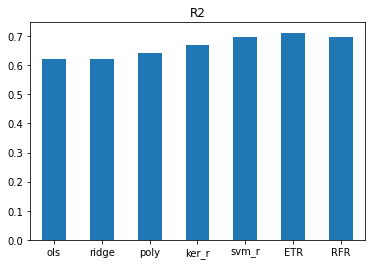

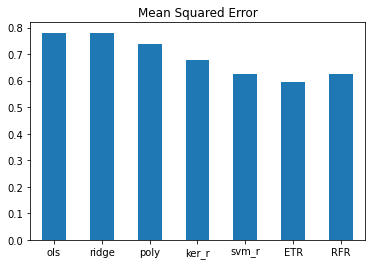

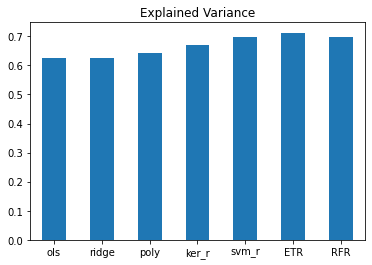

In [11]:
for col in score_df.columns:
    score_df[col].plot.bar(title=col, rot=0)
    plt.show()

In [12]:
score_dict2 = {}
for selected_model in selected_models:
    regr = models[selected_model].set_params(**default_params[selected_model])
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test) 
    score_dict2[selected_model] = score_dict[selected_model] + [metric(y_test, y_pred) for metric in metrics]
score_df2 = pd.DataFrame.from_dict(score_dict2, orient='index',
                                  columns=["Optimal " + s for s in metric_names] + ["Default " + s for s in metric_names])
score_df2 = score_df2[[score_df2.columns[i] for i in [3,0,4,1,5,2]]]
display(score_df2)

,Default R2,Optimal R2,Default Mean Squared Error,Optimal Mean Squared Error,Default Explained Variance,Optimal Explained Variance
ols,0.620982,0.620982,0.780738,0.780738,0.623635,0.623635
ridge,0.621015,0.621009,0.780671,0.780683,0.623642,0.623641
poly,0.641882,0.641882,0.737687,0.737687,0.643488,0.643488
ker_r,-4.052815,0.671146,10.408283,0.677406,-0.903667,0.671460
svm_r,0.696406,0.696447,0.625372,0.625289,0.696904,0.696615
ETR,0.681364,0.711608,0.656358,0.594058,0.683038,0.711852
RFR,0.664107,0.695869,0.691904,0.626479,0.664463,0.696064


4. Το ζητούμενο φαίνεται παραπάνω.
5. Γενικά, είναι ένα μάλλον δύσκολο dataset καθώς δεν ξεπερνάμε εύκολα το 0.7 σε $R^2$ score. Αυτό φαίνεται και από τα plots αλλά και απ'τις διάφορες μετρικές που χρησιμοποιήθηκαν. Με εξαίρεση το kernel regression που ο πυρήνας έχει τεράστια σημασία και αλλάζει πολύ την εικόνα, βλέπουμε μικρή βελτίωση από την διαδικασία της βελιστοποίησης. Όσον αφόρα στους χρόνους, πληρώνουμε την μικρή βελτίωση. Οι ensemble μέθοδοι είναι μία τάξη πιο αργές από τις μεθόδους πυρήνων, οι οποίες με τη σειρά τους είναι μία τάξη πιο αργές από τις γραμμικές.